# Quantum Current Plateau Search via Bayesian Optimization (V7)

## Cross-Coupled Gate Model with Error Analysis
Config (설정) → InstrumentController → CrossCoupledPumpModel (물리모델)
                        ↑↓
              BayesianOptimizer (최적화)

### References:
- Ahn et al., J. Appl. Phys. 122, 194502 (2017)
- Bae et al., Metrologia 57, 065025 (2020)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

FORCE_SIMULATION = True

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.optimize import minimize
from scipy.stats import norm

print('Imports done')

Imports done


In [2]:
class Config:
    e = 1.602176634e-19
    f = 0.350540506e9
    
    @property
    def target_current(self):
        return self.e * self.f
    
    bounds = np.array([[-0.70, -0.54], [-0.70, -0.56], [-0.72, -0.56]])
    n_initial_points = 20
    n_iterations = 80
    early_stop_patience = 20
    log_dir = Path('./experiment_logs')
    experiment_name = f'BO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

class CrossCoupledPumpModel:
    def __init__(self):
        self.Va_base = -0.66
        self.Vb = 0.012
        self.delta2 = 0.05
        self.cross_coupling_ent = 0.30
        self.V_ent_ref = -0.62
        self.V_ent_center = -0.62
        self.ent_width = 0.10
        self.ent_sharpness = 80.0
        self.V_p_center = -0.63
        self.p_width = 0.10
        self.p_sharpness = 60.0
        self.noise_std = 1e-7
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    def effective_Va(self, V_ent):
        return self.Va_base + self.cross_coupling_ent * (V_ent - self.V_ent_ref)
    
    def f_exit(self, V_exit, V_ent):
        Va_eff = self.effective_Va(V_ent)
        arg1 = -(V_exit - Va_eff) / self.Vb
        arg2 = -(V_exit - Va_eff - self.delta2) / self.Vb
        return np.exp(-np.exp(np.clip(arg1,-100,100))) + np.exp(-np.exp(np.clip(arg2,-100,100)))
    
    def f_entrance(self, V_ent):
        V_L, V_R = self.V_ent_center - self.ent_width/2, self.V_ent_center + self.ent_width/2
        return self.sigmoid(self.ent_sharpness*(V_ent-V_L)) * self.sigmoid(-self.ent_sharpness*(V_ent-V_R))
    
    def f_plunger(self, V_p):
        V_L, V_R = self.V_p_center - self.p_width/2, self.V_p_center + self.p_width/2
        return self.sigmoid(self.p_sharpness*(V_p-V_L)) * self.sigmoid(-self.p_sharpness*(V_p-V_R))
    
    def calculate_n_avg(self, V_ent, V_p, V_exit):
        return self.f_exit(V_exit, V_ent) * self.f_entrance(V_ent) * self.f_plunger(V_p) + np.random.normal(0, self.noise_std)
    
    def calculate_current(self, V_ent, V_p, V_exit, config):
        return self.calculate_n_avg(V_ent, V_p, V_exit) * config.e * config.f

print('Model defined')

Model defined


In [3]:
class InstrumentController:
    def __init__(self, config):
        self.config = config
        self.model = CrossCoupledPumpModel()
    
    def measure_current(self, V_ent, V_p, V_exit):
        return self.model.calculate_current(V_ent, V_p, V_exit, self.config)

class BayesianOptimizer:
    def __init__(self, bounds):
        self.bounds = bounds
        self.kernel = ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5) + WhiteKernel(1e-5)
        self.gp = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, normalize_y=True)
        self.X, self.y = [], []
    
    def fit(self, X, y):
        self.X, self.y = np.array(X), np.array(y)
        self.gp.fit(self.X, self.y)
    
    def _expected_improvement(self, x):
        x = np.atleast_2d(x)
        mu, sigma = self.gp.predict(x, return_std=True)
        sigma = np.maximum(sigma, 1e-9)
        y_best = np.min(self.y)
        Z = (y_best - mu) / sigma
        return -((y_best - mu) * norm.cdf(Z) + sigma * norm.pdf(Z))[0]
    
    def suggest(self):
        best_x, best_ei = None, np.inf
        for _ in range(20):
            x0 = np.random.uniform(self.bounds[:,0], self.bounds[:,1])
            res = minimize(self._expected_improvement, x0, bounds=self.bounds, method='L-BFGS-B')
            if res.fun < best_ei:
                best_ei, best_x = res.fun, res.x
        return best_x

class DataLogger:
    def __init__(self, config):
        config.log_dir.mkdir(parents=True, exist_ok=True)
        self.log_file = config.log_dir / f'{config.experiment_name}.csv'
        with open(self.log_file, 'w') as f:
            f.write('iter,V_ent,V_p,V_exit,n_avg,cost\n')
    def log(self, i, V_ent, V_p, V_exit, n_avg, cost):
        with open(self.log_file, 'a') as f:
            f.write(f'{i},{V_ent},{V_p},{V_exit},{n_avg},{cost}\n')

class EarlyStopping:
    def __init__(self, patience=20):
        self.patience, self.best, self.counter = patience, np.inf, 0
    def update(self, cost):
        if cost < self.best - 1e-5:
            self.best, self.counter = cost, 0
        else:
            self.counter += 1
        return self.counter >= self.patience

print('Utilities defined')

Utilities defined


In [4]:
# 4. VISUALIZATION (V7 - Fixed LaTeX)

def generate_pump_map(model, config, v_p_fixed=-0.63, resolution=150):
    v_ent_range = np.linspace(config.bounds[0,0], config.bounds[0,1], resolution)
    v_exit_range = np.linspace(config.bounds[2,0], config.bounds[2,1], resolution)
    V_ENT, V_EXIT = np.meshgrid(v_ent_range, v_exit_range)
    n_map = np.zeros_like(V_ENT)
    for i in range(resolution):
        for j in range(resolution):
            n_map[i,j] = model.f_exit(V_EXIT[i,j], V_ENT[i,j]) * model.f_entrance(V_ENT[i,j]) * model.f_plunger(v_p_fixed)
    return V_ENT, V_EXIT, n_map

def plot_error_analysis(model, config, V_ent_fixed=-0.62, V_p_fixed=-0.63):
    """Bae et al. 2020 Fig.3(b) style"""
    V_exit_range = np.linspace(config.bounds[2,0], config.bounds[2,1], 500)
    n_clean = np.array([model.f_exit(v, V_ent_fixed) * model.f_entrance(V_ent_fixed) * model.f_plunger(V_p_fixed) for v in V_exit_range])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # (a) n vs V_EXIT
    axes[0].plot(V_exit_range, n_clean, 'r-', linewidth=2, label='Model: Double Exponential (Eq.1)')
    axes[0].axhline(1, color='gray', linestyle='--', alpha=0.5, label='n=1 target')
    axes[0].set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    axes[0].set_ylabel(r'$\langle n \rangle$', fontsize=12)
    axes[0].set_title(f'(a) Pump Current vs V_EXIT\n(V_ENT={V_ent_fixed}V, V_P={V_p_fixed}V)', fontsize=11)
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-0.1, 2.2)
    axes[0].text(-0.71, 0.1, 'n=0', fontsize=12, fontweight='bold', color='blue')
    axes[0].text(-0.64, 1.1, 'n=1 plateau', fontsize=11, fontweight='bold', color='green')
    axes[0].text(-0.58, 1.9, 'n=2', fontsize=12, fontweight='bold', color='red')
    
    # (b) |delta Ip| semi-log
    delta_Ip = np.clip(np.abs(n_clean - 1), 1e-12, None)
    axes[1].semilogy(V_exit_range, delta_Ip, 'r-', lw=2, label=r'Model: $|\langle n \rangle - 1|$')
    axes[1].axhline(1e-6, color='blue', ls='--', lw=1.5, label=r'$10^{-6}$ target')
    axes[1].axhline(1e-7, color='purple', ls=':', lw=1.5, label=r'$10^{-7}$ target')
    min_idx = np.argmin(delta_Ip)
    axes[1].plot(V_exit_range[min_idx], delta_Ip[min_idx], 'r*', ms=15, 
                 label=f'Optimal: {delta_Ip[min_idx]:.1e}')
    axes[1].set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    axes[1].set_ylabel(r'$|\delta I_p|$', fontsize=12)
    axes[1].set_title('(b) Error Analysis (cf. Bae et al. 2020 Fig.3b)', fontsize=11)
    axes[1].legend(fontsize=9, loc='upper right')
    axes[1].grid(True, alpha=0.3, which='both')
    axes[1].set_ylim(1e-8, 1e0)
    
    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=150)
    plt.show()
    return V_exit_range[min_idx], delta_Ip[min_idx]

def plot_pump_map_analysis(X_hist, y_hist, config):
    model = CrossCoupledPumpModel()
    X_hist, y_hist = np.array(X_hist), np.array(y_hist)
    best_idx = np.argmin(y_hist)
    best_x = X_hist[best_idx]
    n_total = len(X_hist)
    n_init = config.n_initial_points
    n_bo = n_total - n_init
    
    V_ENT, V_EXIT, n_map = generate_pump_map(model, config, v_p_fixed=best_x[1])
    
    fig = plt.figure(figsize=(18, 13))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1])
    
    # (a) Pump map
    ax1 = fig.add_subplot(gs[0,0])
    cm1 = ax1.pcolormesh(V_ENT, V_EXIT, n_map, cmap='RdYlBu_r', shading='auto', vmin=0, vmax=2)
    cs1 = ax1.contour(V_ENT, V_EXIT, n_map, levels=[1.0], colors='lime', linewidths=3)
    ax1.clabel(cs1, inline=True, fontsize=10, fmt='n=1')
    ax1.scatter(X_hist[:n_init,0], X_hist[:n_init,2], c='white', s=25, alpha=0.6, 
                edgecolors='k', linewidths=0.5, label=f'Initial random ({n_init} pts)')
    ax1.scatter(X_hist[n_init:,0], X_hist[n_init:,2], c='white', s=25, alpha=0.8, 
                edgecolors='blue', linewidths=1, marker='s', label=f'BO samples ({n_bo} pts)')
    n_best = model.f_exit(best_x[2],best_x[0])*model.f_entrance(best_x[0])*model.f_plunger(best_x[1])
    ax1.scatter(best_x[0], best_x[2], c='yellow', marker='*', s=400, edgecolors='k', 
                linewidths=2, label=f'Best (n={n_best:.4f})', zorder=10)
    ax1.text(-0.69, -0.70, 'n=0', fontsize=14, fontweight='bold', color='white', 
             bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7))
    ax1.text(-0.62, -0.62, 'n=1', fontsize=14, fontweight='bold', color='black',
             bbox=dict(boxstyle='round', facecolor='lime', alpha=0.7))
    ax1.text(-0.60, -0.57, 'n=2', fontsize=14, fontweight='bold', color='white',
             bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    ax1.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax1.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax1.set_title(f'(a) Pump Map at V_P={best_x[1]:.3f}V', fontsize=12)
    ax1.legend(fontsize=8, loc='upper right')
    cbar1 = plt.colorbar(cm1, ax=ax1)
    cbar1.set_label(r'$\langle n \rangle$', fontsize=11)
    
    # (b) |dI/dV|
    ax2 = fig.add_subplot(gs[0,1])
    dI = np.abs(np.gradient(n_map, axis=0))
    cm2 = ax2.pcolormesh(V_ENT, V_EXIT, dI, cmap='hot_r', shading='auto', norm=LogNorm(vmin=1e-3, vmax=1))
    cs2 = ax2.contour(V_ENT, V_EXIT, n_map, levels=[1.0], colors='lime', linewidths=2)
    ax2.clabel(cs2, inline=True, fontsize=10, fmt='n=1')
    ax2.scatter(best_x[0], best_x[2], c='cyan', marker='*', s=400, edgecolors='k', linewidths=2, label='Best point')
    ax2.text(-0.69, -0.70, 'n=0', fontsize=12, fontweight='bold', color='white')
    ax2.text(-0.62, -0.62, 'n=1', fontsize=12, fontweight='bold', color='lime')
    ax2.text(-0.60, -0.57, 'n=2', fontsize=12, fontweight='bold', color='white')
    ax2.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax2.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax2.set_title(r'(b) Trans-conductance $|dI/dV_{EXIT}|$', fontsize=12)
    ax2.legend(fontsize=9)
    plt.colorbar(cm2, ax=ax2)
    
    # (c) |delta Ip|
    ax3 = fig.add_subplot(gs[0,2])
    delta_map = np.clip(np.abs(n_map-1), 1e-10, None)
    cm3 = ax3.pcolormesh(V_ENT, V_EXIT, delta_map, cmap='hot_r', shading='auto', norm=LogNorm(vmin=1e-4, vmax=1))
    cs3 = ax3.contour(V_ENT, V_EXIT, delta_map, levels=[1e-3, 1e-2], colors=['lime','yellow'], linewidths=2)
    ax3.clabel(cs3, inline=True, fontsize=9, fmt='%.0e')
    ax3.scatter(best_x[0], best_x[2], c='cyan', marker='*', s=400, edgecolors='k', linewidths=2, label='Best point')
    ax3.text(-0.69, -0.70, 'n=0', fontsize=10, color='white', ha='center')
    ax3.text(-0.62, -0.63, 'n=1', fontsize=10, color='lime', ha='center', fontweight='bold')
    ax3.text(-0.58, -0.57, 'n=2', fontsize=10, color='white', ha='center')
    ax3.set_xlabel(r'$V_{ENT}$ (V)', fontsize=12)
    ax3.set_ylabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax3.set_title(r'(c) Pumping Error $|\delta I_p|$', fontsize=12)
    ax3.legend(fontsize=9)
    plt.colorbar(cm3, ax=ax3)
    
    # (d) Cross-coupling
    ax4 = fig.add_subplot(gs[1,0])
    v_exit_line = np.linspace(config.bounds[2,0], config.bounds[2,1], 300)
    colors_v = plt.cm.viridis(np.linspace(0, 1, 4))
    for v_ent, col in zip([-0.68, -0.64, -0.60, -0.56], colors_v):
        n_line = [model.f_exit(v, v_ent) for v in v_exit_line]
        ax4.plot(v_exit_line, n_line, color=col, lw=2, label=f'V_ENT={v_ent}V')
    ax4.axhline(1, color='g', ls='--', alpha=0.5, label='n=1 target')
    ax4.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax4.set_ylabel(r'$n_{exit}$', fontsize=12)
    ax4.set_title('(d) Cross-Coupling: V_ENT shifts transition', fontsize=11)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(-0.1, 2.2)
    ax4.text(-0.71, 0.1, 'n=0', fontsize=11, fontweight='bold', color='blue')
    ax4.text(-0.64, 1.05, 'n=1', fontsize=11, fontweight='bold', color='green')
    ax4.text(-0.57, 1.9, 'n=2', fontsize=11, fontweight='bold', color='red')
    
    # (e) Fig 3(b) style
    ax5 = fig.add_subplot(gs[1,1])
    n_line_model = np.array([model.f_exit(v, best_x[0])*model.f_entrance(best_x[0])*model.f_plunger(best_x[1]) for v in v_exit_line])
    delta_line = np.clip(np.abs(n_line_model-1), 1e-12, None)
    ax5.semilogy(v_exit_line, delta_line, 'r-', lw=2.5, label='Model: Double Exponential (Eq.1)')
    
    # BO measurements near this V_ENT
    v_ent_tol = 0.02
    near_mask = np.abs(X_hist[:,0] - best_x[0]) < v_ent_tol
    if np.any(near_mask):
        X_near, y_near = X_hist[near_mask], y_hist[near_mask]
        delta_meas = 10**y_near
        ax5.semilogy(X_near[:,2], delta_meas, 'o', ms=8, mfc='steelblue', mec='k',
                     label=f'BO measurements ({len(X_near)} pts)')
    
    ax5.axhline(1e-6, color='blue', ls='--', lw=1.5, label=r'$10^{-6}$ target')
    ax5.axhline(1e-7, color='purple', ls=':', lw=1.5, label=r'$10^{-7}$ target')
    best_delta = 10**y_hist[best_idx]
    ax5.plot(best_x[2], best_delta, '*', ms=20, mfc='yellow', mec='k', mew=2,
             label=f'Best: {best_delta:.2e}')
    ax5.set_xlabel(r'$V_{EXIT}$ (V)', fontsize=12)
    ax5.set_ylabel(r'$|\delta I_p|$', fontsize=12)
    ax5.set_title(f'(e) Error vs V_EXIT at V_ENT={best_x[0]:.3f}V\n(cf. Bae et al. 2020 Fig.3b)', fontsize=11)
    ax5.legend(fontsize=8, loc='upper right')
    ax5.grid(True, alpha=0.3, which='both')
    ax5.set_ylim(1e-8, 1e0)
    
    # (f) History
    ax6 = fig.add_subplot(gs[1,2])
    ax6.scatter(range(n_init), y_hist[:n_init], c='gray', s=50, alpha=0.7, label=f'Initial ({n_init} pts)')
    ax6.scatter(range(n_init, n_total), y_hist[n_init:], c='steelblue', s=50, alpha=0.7, label=f'BO ({n_bo} pts)')
    ax6.plot(np.minimum.accumulate(y_hist), 'r-', lw=2, label='Best so far')
    ax6.scatter(best_idx, y_hist[best_idx], c='yellow', marker='*', s=300, edgecolors='k', linewidths=2, zorder=10, label=f'Best (iter {best_idx})')
    ax6.axvline(n_init, color='green', ls='--', lw=1.5, label='BO start')
    ax6.set_xlabel('Iteration', fontsize=12)
    ax6.set_ylabel(r'Cost = $\log_{10}|\delta I_p|$', fontsize=12)
    ax6.set_title(f'(f) Optimization: {n_total} measurements, Best={y_hist[best_idx]:.2f}', fontsize=11)
    ax6.legend(fontsize=8, loc='upper right')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pump_map_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    n_opt = model.f_exit(best_x[2], best_x[0]) * model.f_entrance(best_x[0]) * model.f_plunger(best_x[1])
    print('='*70)
    print(f'Total measurements: {n_total} ({n_init} initial + {n_bo} BO)')
    print(f'Best: V_ENT={best_x[0]:.4f}, V_P={best_x[1]:.4f}, V_EXIT={best_x[2]:.4f}')
    print(f'<n>={n_opt:.6f}, |delta Ip|={abs(n_opt-1):.2e}')
    print('='*70)
    return best_x, n_opt

print('Visualization defined')


Visualization defined


Bayesian Optimization for Quantum Current Plateau
Iter   0 [INIT]: V=(-0.552,-0.594,-0.690), n=0.0000, cost=-0.00
Iter  10 [INIT]: V=(-0.560,-0.592,-0.686), n=-0.0000, cost=0.00
Iter  20 [BO]: V=(-0.653,-0.668,-0.598), n=0.9701, cost=-1.52
Iter  30 [BO]: V=(-0.628,-0.576,-0.619), n=0.4839, cost=-0.29
Iter  40 [BO]: V=(-0.649,-0.590,-0.593), n=1.0325, cost=-1.49
Iter  50 [BO]: V=(-0.599,-0.640,-0.687), n=0.0000, cost=-0.00
Iter  60 [BO]: V=(-0.620,-0.582,-0.569), n=0.9980, cost=-2.70
Iter  70 [BO]: V=(-0.636,-0.566,-0.575), n=0.5451, cost=-0.34
Iter  80 [BO]: V=(-0.650,-0.590,-0.592), n=1.0066, cost=-2.18
Early Stopping!
Complete!


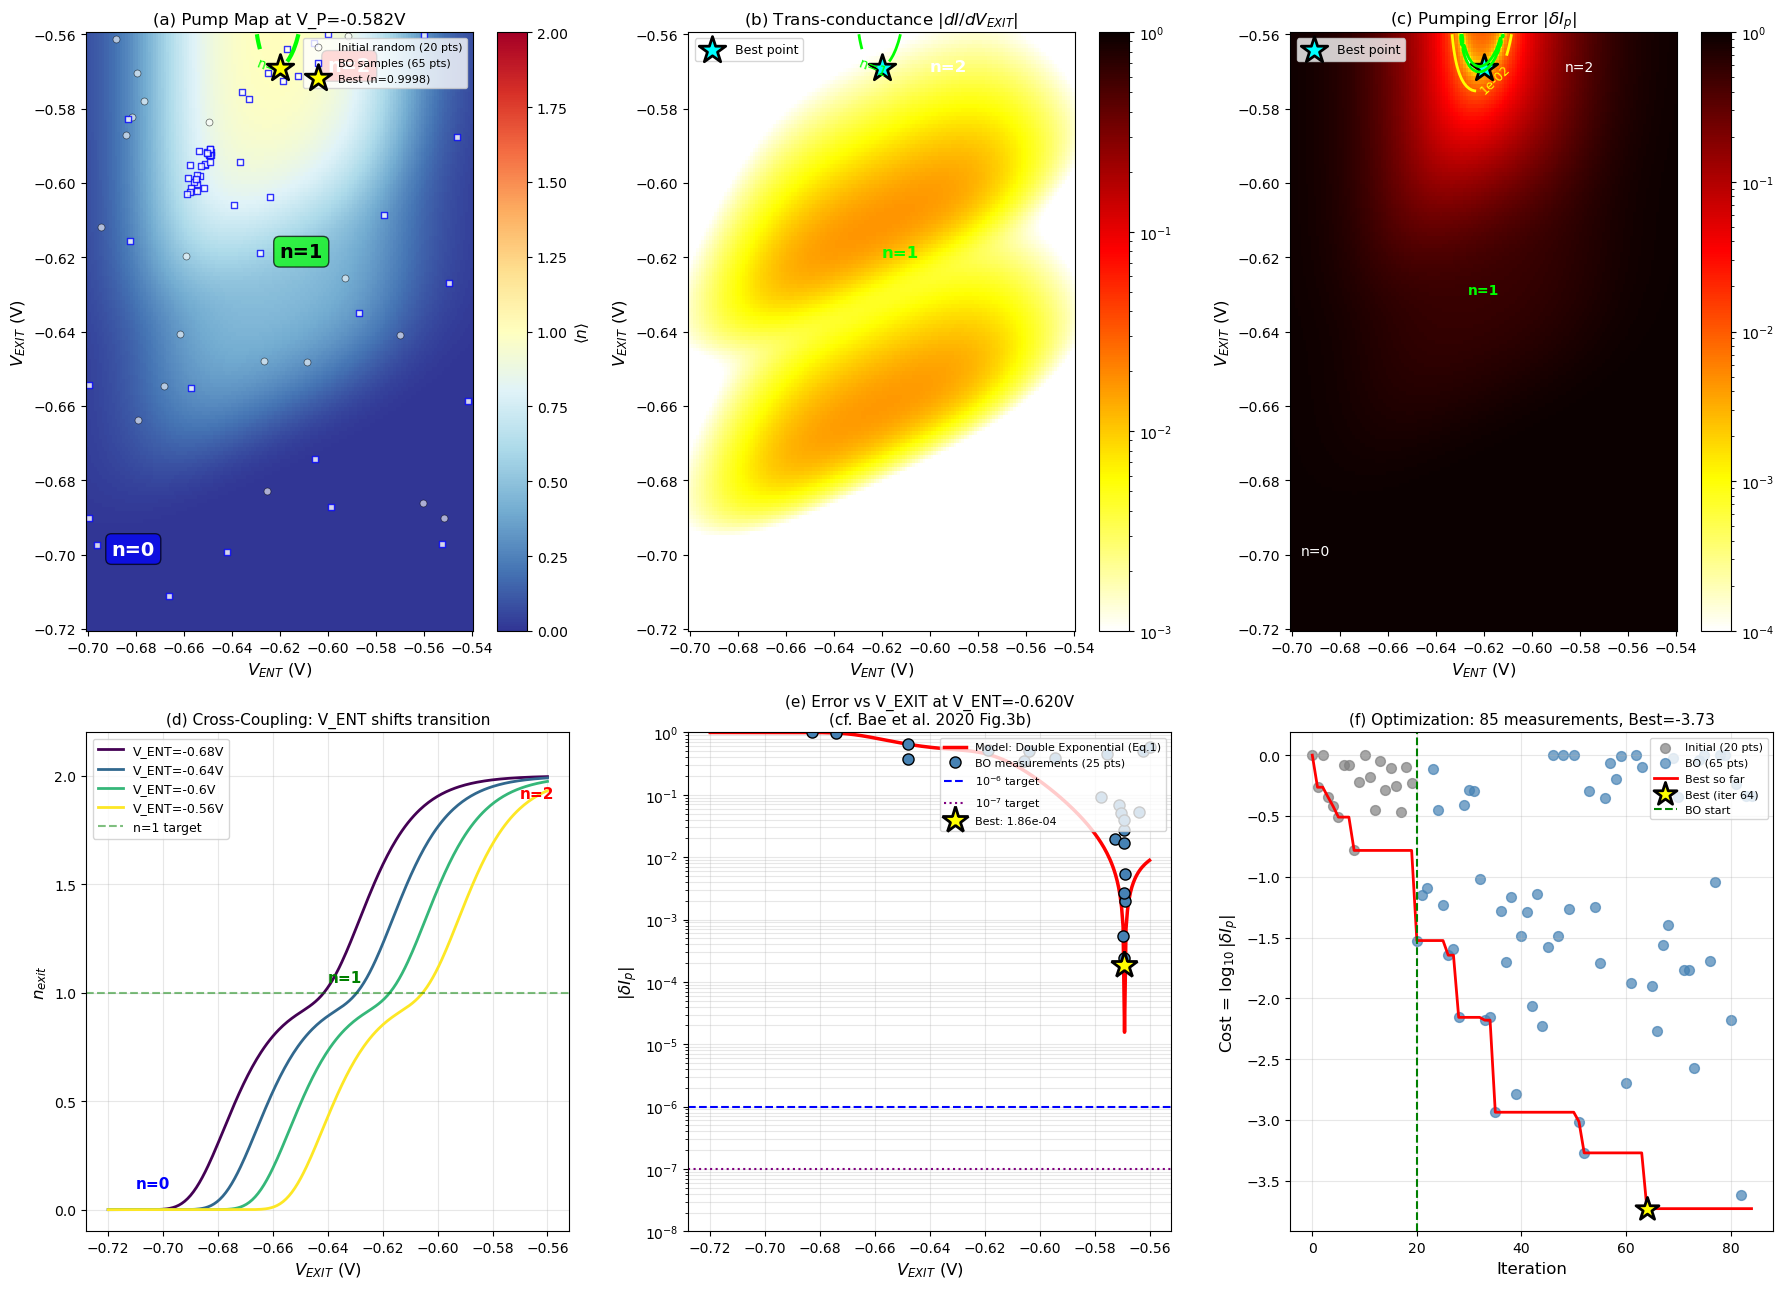

Total measurements: 85 (20 initial + 65 BO)
Best: V_ENT=-0.6198, V_P=-0.5819, V_EXIT=-0.5692
<n>=0.999814, |delta Ip|=1.86e-04


In [5]:
def run_experiment():
    cfg = Config()
    instr = InstrumentController(cfg)
    bo = BayesianOptimizer(cfg.bounds)
    logger = DataLogger(cfg)
    stop = EarlyStopping()
    X_hist, y_hist = [], []
    
    print('='*60)
    print('Bayesian Optimization for Quantum Current Plateau')
    print('='*60)
    
    for i in range(cfg.n_initial_points + cfg.n_iterations):
        phase = 'INIT' if i < cfg.n_initial_points else 'BO'
        if phase == 'INIT':
            x_next = np.random.uniform(cfg.bounds[:,0], cfg.bounds[:,1])
        else:
            bo.fit(X_hist, y_hist)
            x_next = bo.suggest()
        
        cur = instr.measure_current(*x_next)
        n_avg = cur / cfg.target_current
        cost = np.log10(np.abs(n_avg - 1) + 1e-15)
        
        X_hist.append(x_next)
        y_hist.append(cost)
        logger.log(i, *x_next, n_avg, cost)
        
        if i % 10 == 0:
            print(f'Iter {i:3d} [{phase}]: V=({x_next[0]:.3f},{x_next[1]:.3f},{x_next[2]:.3f}), n={n_avg:.4f}, cost={cost:.2f}')
        
        if phase == 'BO' and stop.update(cost):
            print('Early Stopping!')
            break
    
    print('Complete!')
    return X_hist, y_hist, cfg

X_hist, y_hist, cfg = run_experiment()
best_point, best_n = plot_pump_map_analysis(X_hist, y_hist, cfg)

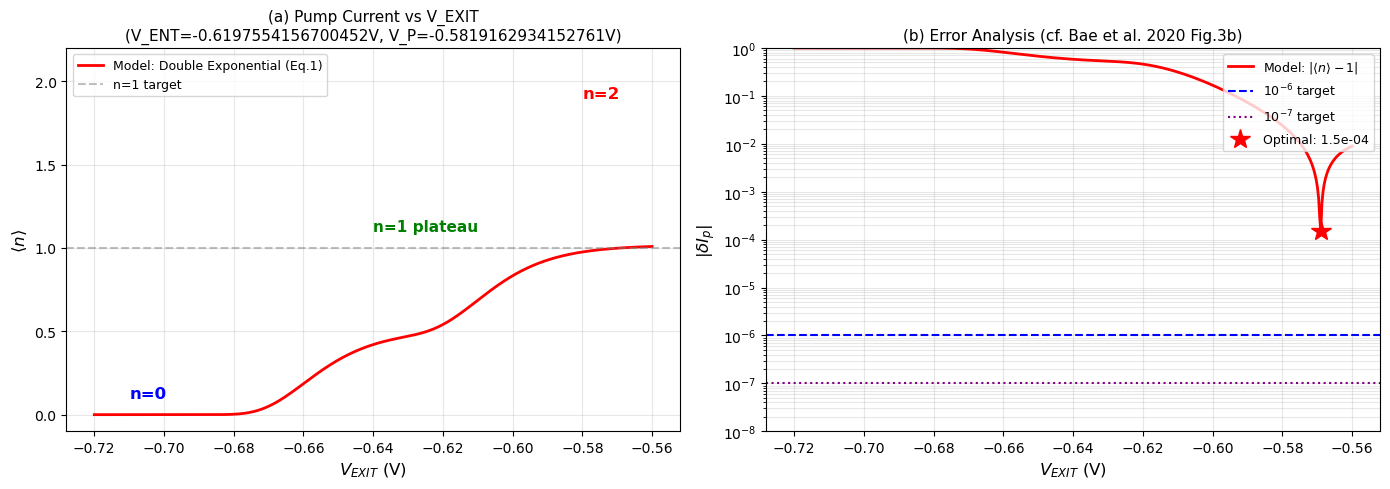

Optimal V_EXIT: -0.5690 V
Minimum |delta Ip|: 1.49e-04


In [6]:
model = CrossCoupledPumpModel()
min_v, min_delta = plot_error_analysis(model, cfg, V_ent_fixed=best_point[0], V_p_fixed=best_point[1])
print(f'Optimal V_EXIT: {min_v:.4f} V')
print(f'Minimum |delta Ip|: {min_delta:.2e}')